In [156]:
import pandas as pd
import numpy as np
import cyrtranslit
import re
import pycountry
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from scipy.sparse import hstack
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [157]:
train = pd.read_csv('/Users/yakovlev/Downloads/train _sibur.csv', index_col='pair_id')
train

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0
...,...,...,...
497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0
497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0
497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0


In [158]:
train.shape

(497819, 3)

In [159]:
train

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0
...,...,...,...
497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0
497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0
497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0


In [160]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [161]:
train.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


В данных нет дубликатов

Напишем функцию, которая получая str на вход, будет оставлять только латинские буквы нижнего регистра

In [162]:
porter = PorterStemmer()
def stemming(sentence):
    word_list = []
    for i in sentence.split():
        word_list.append(porter.stem(i))
    word_list = " ".join(word_list)
    return " ".join(re.sub(r'[^A-Za-z]', " ", word_list).split())

In [163]:
train

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0
...,...,...,...
497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0
497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0
497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0


Применим данную функцию к датасету train

In [164]:
train['name_1'] = train['name_1'].apply(stemming).copy()
train['name_2'] = train['name_2'].apply(stemming)
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko industri ltd,enorm industri trade pvt ltd,0
2,apcotex industri ltd,technocraft industri india ltd,0
3,rishichem distributor pvt ltd,dsa,0
4,powermax rubber factori,co one,0
5,tress a,longyou industri park zhejiang,0


Разобьем данные на токены, для этого воспользуемся RegexpTokenizer. В результате получим новые столбцы tokens1 и tokens2 состоящие из списка слов

In [165]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

train["tokens1"] = train['name_1'].apply(tokenizer.tokenize)
train["tokens2"] = train['name_2'].apply(tokenizer.tokenize)
train.head()

,name_1,name_2,is_duplicate,tokens1,tokens2
pair_id,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,"[iko, industri, ltd]","[enorm, industri, trade, pvt, ltd]"
2,apcotex industri ltd,technocraft industri india ltd,0,"[apcotex, industri, ltd]","[technocraft, industri, india, ltd]"
3,rishichem distributor pvt ltd,dsa,0,"[rishichem, distributor, pvt, ltd]",[dsa]
4,powermax rubber factori,co one,0,"[powermax, rubber, factori]","[co, one]"
5,tress a,longyou industri park zhejiang,0,"[tress, a]","[longyou, industri, park, zhejiang]"


Найдем самые частовстречающиеся слова

In [166]:
all_words = [word for tokens in pd.concat([train['tokens1'], train['tokens2']]) for word in tokens]
for tokens in train["tokens1"]:
    for word in tokens:
        all_words.append(word)
len(all_words)

5788837

In [167]:
Counter(all_words).most_common(30)

[('ltd', 417253),
 ('co', 238680),
 ('inc', 148187),
 ('intern', 147263),
 ('industri', 145599),
 ('De', 135686),
 ('trade', 100921),
 ('a', 85191),
 ('logist', 82399),
 ('s', 81946),
 ('pvt', 64454),
 ('rubber', 63608),
 ('india', 53961),
 ('privat', 50301),
 ('Sa', 49016),
 ('llc', 47534),
 ('S', 46979),
 ('Cv', 43533),
 ('ltda', 42228),
 ('c', 41814),
 ('chemic', 39494),
 ('product', 36827),
 ('shanghai', 34276),
 ('plastic', 34270),
 ('mexico', 33989),
 ('imp', 31784),
 ('corp', 31631),
 ('corpor', 31546),
 ('v', 31197),
 ('exp', 30618)]

Запишем функцию, которая добавляет x самых частовречающихся слов. x - гиперпараметр, который нужно подбирать при обучении модели

In [168]:
stop_words = []
for x, _ in Counter(all_words).most_common(140):
    stop_words.append(x)  

In [169]:
stop_words = set(stop_words)

Запишем функцию, которая получая на вход строку таблицы, удаляет самые частовречающиеся слова и убирает те слова, длина которых меньше 3 символов. Это она делает для столобцов tokens1 и tokens2

In [170]:
def cleaning_tokens(row):
    seq_tok1 = []
    for word in row['tokens1']:
        if (word not in stop_words) and (len(word) >= 3):
          seq_tok1.append(word)
    row['tokens1'] = " ".join(seq_tok1)
    
    seq_tok2 = []
    for word in row['tokens2']:
        if (word not in stop_words) and (len(word) >= 3):
          seq_tok2.append(word)
    row['tokens2'] = " ".join(seq_tok2)
    return row

In [171]:
train = train.apply(cleaning_tokens, axis=1)
train.head()

,name_1,name_2,is_duplicate,tokens1,tokens2
pair_id,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,technocraft
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,dsa
4,powermax rubber factori,co one,0,powermax factori,one
5,tress a,longyou industri park zhejiang,0,tress,longyou park zhejiang


In [172]:
countries = [country.name.lower() for country in pycountry.countries]
for country in tqdm(countries):
    train['tokens1'].replace(re.compile(country), "", inplace=True)
    train['tokens2'].replace(re.compile(country), "", inplace=True)

100%|██████████| 249/249 [04:59<00:00,  1.20s/it]


Считаем тестовые данные и выполним функцию стемминга

In [173]:
test = pd.read_csv('/Users/yakovlev/Downloads/test_sibur.csv', index_col='pair_id')
test['name_1'] = test['name_1'].apply(stemming).copy()
test['name_2'] = test['name_2'].apply(stemming)
test.head()

,name_1,name_2
pair_id,,
1,sun blind decor inc,indl De cuautitlan Sa Cv
2,eih ltd,dongguan wei shi plastic product co ltd
3,jsh ltd hk,arab shipbuild and repair yard C
4,better industri ltd,farmacap industria E comercio ltda
5,equipo inoxid del nort Sa De Cv,bel inc


Разобьем слова на токены

In [174]:
test["tokens1"] = test['name_1'].apply(tokenizer.tokenize)
test["tokens2"] = test['name_2'].apply(tokenizer.tokenize)

Почистим токены и переведем список в строку

In [175]:
test = test.apply(cleaning_tokens, axis=1)
test.head()

,name_1,name_2,tokens1,tokens2
pair_id,,,,
1,sun blind decor inc,indl De cuautitlan Sa Cv,sun blind decor,indl cuautitlan
2,eih ltd,dongguan wei shi plastic product co ltd,eih,wei shi
3,jsh ltd hk,arab shipbuild and repair yard C,jsh,arab shipbuild repair yard
4,better industri ltd,farmacap industria E comercio ltda,better,farmacap
5,equipo inoxid del nort Sa De Cv,bel inc,equipo inoxid del nort,bel


In [176]:
countries = [country.name.lower() for country in pycountry.countries]
for country in tqdm(countries):
    test['tokens1'].replace(re.compile(country), "", inplace=True)
    test['tokens2'].replace(re.compile(country), "", inplace=True)

100%|██████████| 249/249 [02:10<00:00,  1.90it/s]


# Простые метрики сходства строк

## Левенштейн

In [177]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
 3   tokens1       497819 non-null  object
 4   tokens2       497819 non-null  object
dtypes: int64(1), object(4)
memory usage: 22.8+ MB


In [178]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
from tqdm import tqdm
tqdm.pandas()

/Users/yakovlev/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [179]:
levenshtein = Levenshtein()

train["levenstein"] = train.apply(lambda r: levenshtein.distance(r.tokens1, r.tokens2), axis=1)
test["levenstein"] = test.apply(lambda r: levenshtein.distance(r.tokens1, r.tokens2), axis=1)

In [180]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein"] = train.apply(lambda r: normalized_levenshtein.distance(r.tokens1, r.tokens2),
                                                axis=1)
test["norm_levenstein"] = test.apply(lambda r: normalized_levenshtein.distance(r.tokens1, r.tokens2),
                                              axis=1)

In [181]:
print('mean для класса 1', train[train['is_duplicate'] == 1]['norm_levenstein'].mean())

mean для класса 1 0.512509144557179


In [182]:
print('mean для класса 0', train[train['is_duplicate'] == 0]['norm_levenstein'].mean())

mean для класса 0 0.8646763714358655


In [183]:
test.head()

,name_1,name_2,tokens1,tokens2,levenstein,norm_levenstein
pair_id,,,,,,
1,sun blind decor inc,indl De cuautitlan Sa Cv,sun blind decor,indl cuautitlan,15.0,1.000000
2,eih ltd,dongguan wei shi plastic product co ltd,eih,wei shi,4.0,0.571429
3,jsh ltd hk,arab shipbuild and repair yard C,jsh,arab shipbuild repair yard,24.0,0.923077
4,better industri ltd,farmacap industria E comercio ltda,better,farmacap,8.0,1.000000
5,equipo inoxid del nort Sa De Cv,bel inc,equipo inoxid del nort,bel,20.0,0.909091


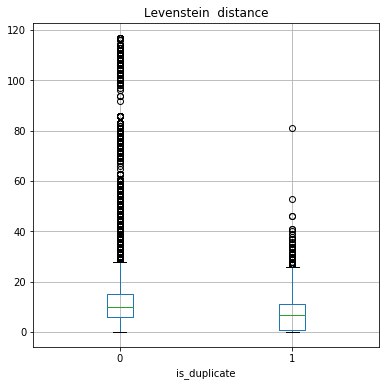

In [184]:
plt.figure(figsize=(6,6))

train.boxplot("levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Levenstein  distance", fontsize=12);

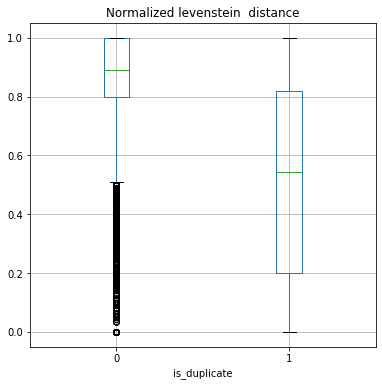

In [185]:
plt.figure(figsize=(6,6))

train.boxplot("norm_levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Normalized levenstein  distance", fontsize=12);

## Джакар

Реализация Jacaard Similiarity

In [186]:
def get_jaccard_sim(row):
    if (row['name_1'] == '') or (row['name_2'] == ''):
        return 0
    else:
        a = set(row['name_1'].split()) 
        b = set(row['name_2'].split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))

In [187]:
train.head()

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein
pair_id,,,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm,4.0,0.800000
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,technocraft,9.0,0.818182
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,dsa,19.0,0.904762
4,powermax rubber factori,co one,0,powermax factori,one,14.0,0.875000
5,tress a,longyou industri park zhejiang,0,tress,longyou park zhejiang,19.0,0.904762


In [188]:
train['jacaard_sim'] = train.apply(get_jaccard_sim, axis=1)
test['jacaard_sim'] = test.apply(get_jaccard_sim, axis=1)

In [189]:
train.head()

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim
pair_id,,,,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm,4.0,0.800000,0.333333
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,technocraft,9.0,0.818182,0.400000
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,dsa,19.0,0.904762,0.000000
4,powermax rubber factori,co one,0,powermax factori,one,14.0,0.875000,0.000000
5,tress a,longyou industri park zhejiang,0,tress,longyou park zhejiang,19.0,0.904762,0.000000


In [190]:
test.head()

,name_1,name_2,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim
pair_id,,,,,,,
1,sun blind decor inc,indl De cuautitlan Sa Cv,sun blind decor,indl cuautitlan,15.0,1.000000,0.000
2,eih ltd,dongguan wei shi plastic product co ltd,eih,wei shi,4.0,0.571429,0.125
3,jsh ltd hk,arab shipbuild and repair yard C,jsh,arab shipbuild repair yard,24.0,0.923077,0.000
4,better industri ltd,farmacap industria E comercio ltda,better,farmacap,8.0,1.000000,0.000
5,equipo inoxid del nort Sa De Cv,bel inc,equipo inoxid del nort,bel,20.0,0.909091,0.000


## Cosine similarity

In [191]:
from scipy import spatial

Обучим tfidf на большом корпусе слов, для этого заканкатим tokens1 и tokens2 у train выборки

In [192]:
tfidf = TfidfVectorizer()

In [193]:
corpus = pd.concat([train['tokens1'], train['tokens2']]).values.astype('U')
len(corpus)

995638

In [194]:
tfidf.fit(corpus)

TfidfVectorizer()

In [195]:
tf_tokens_1 = tfidf.transform(train['tokens1'])
tf_tokens_1.shape

(497819, 14422)

In [196]:
tf_tokens_1.getrow(0).A[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [197]:
tf_tokens_2 = tfidf.transform(train['tokens2'])
tf_tokens_2.shape

(497819, 14422)

In [198]:
li = []
for i in range(tf_tokens_1.shape[0]):
    li.append(1 - spatial.distance.cosine(tf_tokens_1.getrow(i).A[0], tf_tokens_2.getrow(i).A[0]))

/Users/yakovlev/opt/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [199]:
len(li)

497819

In [200]:
train['cos_sim'] = li
train.head()

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim,cos_sim
pair_id,,,,,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm,4.0,0.800000,0.333333,0.0
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,technocraft,9.0,0.818182,0.400000,0.0
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,dsa,19.0,0.904762,0.000000,0.0
4,powermax rubber factori,co one,0,powermax factori,one,14.0,0.875000,0.000000,0.0
5,tress a,longyou industri park zhejiang,0,tress,longyou park zhejiang,19.0,0.904762,0.000000,0.0


In [201]:
tf_tokens_1 = tfidf.transform(test['tokens1'])
tf_tokens_1.shape

(213249, 14422)

In [202]:
tf_tokens_2 = tfidf.transform(test['tokens2'])
tf_tokens_2.shape

(213249, 14422)

In [203]:
li_test = []
for i in range(tf_tokens_1.shape[0]):
    li_test.append(1 - spatial.distance.cosine(tf_tokens_1.getrow(i).A[0], tf_tokens_2.getrow(i).A[0]))

/Users/yakovlev/opt/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [204]:
len(li_test)

213249

In [205]:
test['cos_sim'] = li_test

In [206]:
train[(train['cos_sim'].isna()) & (train['is_duplicate'] == 1)]

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim,cos_sim
pair_id,,,,,,,,,
1787,Pt bridgeston tire indonesia,bridgeston Do brasil industria E comenrcio ltda,1,,comenrcio,9.0,1.0,0.100000,NaN
2055,Pt bridgeston tire indonesia,thai bridgeston co ltd,1,,thai,4.0,1.0,0.142857,NaN
2799,bridgeston america tire,bridgeston intern group,1,,,0.0,0.0,0.200000,NaN
3372,,,1,,,0.0,0.0,0.000000,NaN
4286,bridgeston De mexico s a De c v,bridgeston ncr,1,,ncr,3.0,1.0,0.125000,NaN
...,...,...,...,...,...,...,...,...,...
495751,bridgeston india,bridgeston fireston venezolana,1,,fireston venezolana,19.0,1.0,0.250000,NaN
496076,bridgeston De mexico s a De c v,bridgeston De costa rica s a,1,,,0.0,0.0,0.444444,NaN
496238,bridgeston stargard Sp zoo,bridgeston intern group,1,stargard zoo,,12.0,1.0,0.166667,NaN


In [207]:
train['cos_sim'].fillna(0, inplace=True)
test['cos_sim'].fillna(0, inplace=True)

## Jaro Winkler

In [208]:
from strsimpy.jaro_winkler import JaroWinkler

In [209]:
jarowinkler = JaroWinkler()

In [210]:
train['jaro_winkler'] = train.apply(lambda x: jarowinkler.similarity(x['tokens1'], x['tokens2']), axis=1)

In [211]:
train.head()

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim,cos_sim,jaro_winkler
pair_id,,,,,,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm,4.0,0.800000,0.333333,0.0,0.511111
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,technocraft,9.0,0.818182,0.400000,0.0,0.478355
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,dsa,19.0,0.904762,0.000000,0.0,0.460317
4,powermax rubber factori,co one,0,powermax factori,one,14.0,0.875000,0.000000,0.0,0.597222
5,tress a,longyou industri park zhejiang,0,tress,longyou park zhejiang,19.0,0.904762,0.000000,0.0,0.415873


In [212]:
test['jaro_winkler'] = test.apply(lambda x: jarowinkler.similarity(x['tokens1'], x['tokens2']), axis=1)

In [213]:
test.head()

,name_1,name_2,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim,cos_sim,jaro_winkler
pair_id,,,,,,,,,
1,sun blind decor inc,indl De cuautitlan Sa Cv,sun blind decor,indl cuautitlan,15.0,1.000000,0.000,0.0,0.488889
2,eih ltd,dongguan wei shi plastic product co ltd,eih,wei shi,4.0,0.571429,0.125,0.0,0.650794
3,jsh ltd hk,arab shipbuild and repair yard C,jsh,arab shipbuild repair yard,24.0,0.923077,0.000,0.0,0.581197
4,better industri ltd,farmacap industria E comercio ltda,better,farmacap,8.0,1.000000,0.000,0.0,0.430556
5,equipo inoxid del nort Sa De Cv,bel inc,equipo inoxid del nort,bel,20.0,0.909091,0.000,0.0,0.459596


## Damerau-Levenshtein distance

In [214]:
from strsimpy.damerau import Damerau

In [215]:
damerau = Damerau()

In [216]:
train['damerau'] = train.apply(lambda x: damerau.distance(x['tokens1'], x['tokens2']), axis=1)

In [217]:
test['damerau'] = test.apply(lambda x: damerau.distance(x['tokens1'], x['tokens2']), axis=1)

## QGram

In [218]:
from strsimpy.qgram import QGram

In [219]:
train.head(1)

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim,cos_sim,jaro_winkler,damerau
pair_id,,,,,,,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm,4.0,0.8,0.333333,0.0,0.511111,4.0


In [220]:
qgram = QGram()

In [221]:
qgram.distance(train.iloc[1]['tokens1'], train.iloc[1]['tokens2'])

14

In [222]:
qgram = QGram(2)
train['qram'] = train.apply(lambda x: qgram.distance(x.tokens1, x.tokens2), axis=1)

In [223]:
test['qram'] = test.apply(lambda x: qgram.distance(x.tokens1, x.tokens2), axis=1)

# Базовая модель

In [224]:
train

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim,cos_sim,jaro_winkler,damerau,qram
pair_id,,,,,,,,,,,,
1,iko industri ltd,enorm industri trade pvt ltd,0,iko,enorm,4.0,0.800000,0.333333,0.0,0.511111,4.0,6.0
2,apcotex industri ltd,technocraft industri india ltd,0,apcotex,technocraft,9.0,0.818182,0.400000,0.0,0.478355,9.0,14.0
3,rishichem distributor pvt ltd,dsa,0,rishichem distributor,dsa,19.0,0.904762,0.000000,0.0,0.460317,19.0,22.0
4,powermax rubber factori,co one,0,powermax factori,one,14.0,0.875000,0.000000,0.0,0.597222,14.0,17.0
5,tress a,longyou industri park zhejiang,0,tress,longyou park zhejiang,19.0,0.904762,0.000000,0.0,0.415873,19.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...
497815,bit mat product,the goodyear tire and rubber compani,0,bit mat,goodyear compani,13.0,0.812500,0.000000,0.0,0.427579,13.0,21.0
497816,bnd trade co ltd,zhong shan yue liang economy trade imp exp co ltd,0,bnd,zhong shan yue liang economy,27.0,0.964286,0.272727,0.0,0.456349,27.0,29.0
497817,xeikon industri co ltd Of dongguan citi,Yi cheng trade co ltd Of dongguan citi,0,xeikon,cheng,6.0,1.000000,0.500000,0.0,0.577778,6.0,9.0


In [225]:
from sklearn.model_selection import StratifiedShuffleSplit

In [226]:
FTS = ["levenstein", "jacaard_sim", "cos_sim", 'jaro_winkler', 'damerau']
THR = 0.99

In [227]:
train[FTS].corr()

,levenstein,jacaard_sim,cos_sim,jaro_winkler,damerau
levenstein,1.000000,-0.231387,-0.073679,-0.002287,0.999941
jacaard_sim,-0.231387,1.000000,0.219125,0.056649,-0.231417
cos_sim,-0.073679,0.219125,1.000000,0.241262,-0.073664
jaro_winkler,-0.002287,0.056649,0.241262,1.000000,-0.002883
damerau,0.999941,-0.231417,-0.073664,-0.002883,1.000000


In [228]:
split = StratifiedShuffleSplit(5, train_size=0.8, random_state=12345)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [229]:
model = LogisticRegression(class_weight='balanced', random_state=12345)
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

LogisticRegression(class_weight='balanced', random_state=12345)

In [230]:
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

In [231]:
tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

In [232]:
print(classification_report(train.iloc[tridx]["is_duplicate"].values, tr_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    395329
           1       0.49      0.34      0.40      2926

    accuracy                           0.99    398255
   macro avg       0.74      0.67      0.70    398255
weighted avg       0.99      0.99      0.99    398255



In [233]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98832
           1       0.48      0.34      0.40       732

    accuracy                           0.99     99564
   macro avg       0.74      0.67      0.70     99564
weighted avg       0.99      0.99      0.99     99564



In [155]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.5658901547355892
0.5652759084791386


In [782]:
0.5658901547355892 132
0.5652759084791386

0.5652759084791386

In [697]:
train.iloc[tridx].head(3)

,name_1,name_2,is_duplicate,tokens1,tokens2,levenstein,norm_levenstein,jacaard_sim,cos_sim,jaro_winkler,damerau,qram
210165,mitsui chemic america,gme chemic s pte ltd,0,mitsui,gme pte,6.0,0.857143,0.142857,0.0,0.436508,6.0,11.0
319435,K C logist co ltd,sunni intern logist inc,0,,sunni,5.0,1.000000,0.125000,0.0,0.000000,5.0,4.0
103757,Ol usa,imeri usa inc,0,,imeri,5.0,1.000000,0.250000,0.0,0.000000,5.0,4.0


In [790]:
train.iloc[cvidx]['is_duplicate'].values

pair_id
451292    0
359557    0
273592    0
371329    0
315110    0
         ..
253711    0
242222    0
497265    0
495057    0
214183    0
Name: is_duplicate, Length: 99564, dtype: int64

In [792]:
cv_preds

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
def show_error()

# Сабмит

In [698]:
len((model.predict_proba(test[FTS].values)[:, 1] > THR).astype(np.int))

213249

In [699]:
test['is_duplicate'] = (model.predict_proba(test[FTS].values)[:, 1] > THR).astype(np.int)
test['is_duplicate'].value_counts()

0    212566
1       683
Name: is_duplicate, dtype: int64

In [700]:
output = pd.DataFrame(test['is_duplicate'])
output

,is_duplicate
pair_id,
1,0
2,0
3,0
4,0
5,0
...,...
213245,0
213246,0
213247,0


In [701]:
output.to_csv('output.csv')

In [702]:
output

,is_duplicate
pair_id,
1,0
2,0
3,0
4,0
5,0
...,...
213245,0
213246,0
213247,0
